In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.signal import find_peaks
from qiskit import IBMQ
from qiskit import pulse
import qiskit.pulse.library as pulse_lib
from qiskit.compiler import assemble
from qiskit.tools.monitor import job_monitor
from scipy.optimize import curve_fit

In [2]:
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
backends =provider.backends()

In [3]:
def match_sine(X,ps,booltPlot=True):
    
    N=len(X)
    
    #init parameter
    C = np.mean(X)
    B = (np.max(X)-np.min(X))/2
    
    #init frequency
    Y = np.fft.fft(X - C)
    Y = np.abs(Y[:int(N/2)])
    
    imax = np.argmax(Y)
    y0 = Y[imax]
    yl = Y[imax-1]
    yr = Y[imax+1]

    a = (yl+yr)/2 - y0
    b = (yr-yl)/2
    c = y0

    x = -b/(2*a)
    dp = ps[1]-ps[0]
    p_opt = dp*(N-1)/(imax + x)/2
    
    #optim
    init_param = [p_opt, 0, -B, C]
    function = lambda f, fc, A, B, C: A*np.sin(np.pi*f/fc)+B*np.cos(np.pi*f/fc)+C
    params, conv = curve_fit(function, ps, X, init_param)
    X_model = function(ps, *params)
    
    if booltPlot == True:
        plt.plot(ps,X)
        plt.plot(ps,function(ps,*init_param))
        plt.plot(ps,X_model)
    
    return params

In [4]:
def match_sinc2(X,fs,boolPlot=True):
    
    #initial parameters
    B = np.min(X)
    fc = fs[np.argmax(X)]
    A = np.max(X) - B
    X_norm = (X - B)/A
    x_mean = np.mean(X_norm)
    df = x_mean*(np.max(fs)-np.min(fs))/np.pi/3
    
    #fit
    function = lambda f, fc, df, A, B: A*np.sinc((f-fc)/df)**2+B
    params, conv = curve_fit(function, fs, X, [fc, df, A, B])
    X_model = function(fs, *params)
    
#     (params, X_model) =fit_function(fs,X,function,[fc, df, A, B])
    
    if boolPlot == True:
        plt.scatter(fs,X,c='k')
        plt.plot(fs,X_model,c='b')
    
    return params

In [55]:
# number of shots for our experiments
NUM_SHOTS = 1024
SIGMA = 75e-9
TRUNC = 8
MAXFREQS = 75
MAXDRIVE = 0.1
SAMPLE = 16
SCALE = 1e-14

class Calibration:
    def __init__(self,backend='ibmq_armonk'):
        self.backend = provider.get_backend(backend)
        self.backend_config = self.backend.configuration()
        assert self.backend_config.open_pulse, "Backend doesn't support Pulse"
        self.dt = self.backend_config.dt
        self.backend_defaults = self.backend.defaults()
        
    def frequency01_schedules(self,span_range=1/200,qbit=0):
        schedules = []
        self.f01_default = self.backend_defaults.qubit_freq_est[qbit]
        span = self.f01_default*span_range
        frequencies = np.linspace(-span, span, MAXFREQS)

        # Define the drive pulse
        drive_sigma = SAMPLE * round(SIGMA/ SAMPLE/ self.dt)       # The width of the gaussian in units of dt
        drive_samples = TRUNC * drive_sigma   # The truncating parameter in units of dt
        drive_power = MAXDRIVE
        gauss = pulse_lib.gaussian(duration=drive_samples,
                                                  sigma=drive_sigma,
                                                  amp=drive_power,
                                                  name='ground_sweep_drive_pulse')
        
        for freq in frequencies:
            with pulse.build(backend=self.backend) as spec:
                with pulse.align_sequential():
                    pulse.shift_frequency(freq, pulse.DriveChannel(qbit))
                    pulse.play(gauss, pulse.DriveChannel(qbit))
                    pulse.measure(qbit)

            schedules.append(spec)
        
        return frequencies,schedules
    
    def amplitude01_schedules(self,max_amp=1.0,qbit=0):
        schedules = []
        drive_powers = np.linspace(0, max_amp, MAXFREQS)

        # Define the drive pulse
        drive_sigma = SAMPLE * round(SIGMA/ SAMPLE/ self.dt)       # The width of the gaussian in units of dt
        drive_samples = TRUNC * drive_sigma   # The truncating parameter in units of dt

        for drive_power in drive_powers:
            gauss = pulse_lib.gaussian(duration=drive_samples,sigma=drive_sigma,amp=drive_power)
            with pulse.build(backend=self.backend) as spec:
                with pulse.align_sequential():
                    pulse.shift_frequency(self.df01_calib, pulse.DriveChannel(qbit))
                    pulse.play(gauss, pulse.DriveChannel(qbit))
                    pulse.measure(qbit)

            schedules.append(spec)
        
        return drive_powers,schedules
    
    def frequency12_schedules(self,span_range=1/200,qbit=0,span=[-0.36e9, -0.32e9]):
        schedules = []
        frequencies = np.linspace(span[0],span[1], MAXFREQS)

        # Define the drive pulse
        gauss = self.pulse_rx01()
        
        for freq in frequencies:
            with pulse.build(backend=self.backend) as spec:
                with pulse.align_sequential():
                    pulse.shift_frequency(self.df01_calib, pulse.DriveChannel(qbit))
                    pulse.play(gauss, pulse.DriveChannel(0))
                    pulse.shift_frequency(freq, pulse.DriveChannel(qbit))
                    pulse.play(gauss, pulse.DriveChannel(qbit))
                    pulse.measure(qbit)

            schedules.append(spec)
        
        return frequencies,schedules
    
    def amplitude12_schedules(self,max_amp=1.0,qbit=0):
        schedules = []
        drive_powers = np.linspace(0, max_amp, MAXFREQS)

        # Define the drive pulse
        drive_sigma = SAMPLE * round(SIGMA/ SAMPLE/ self.dt)       # The width of the gaussian in units of dt
        drive_samples = TRUNC * drive_sigma   # The truncating parameter in units of dt

        for drive_power in drive_powers:
            gauss = pulse_lib.gaussian(duration=drive_samples,sigma=drive_sigma,amp=drive_power)
            with pulse.build(backend=self.backend) as spec:
                with pulse.align_sequential():
                    pulse.shift_frequency(self.df01_calib, pulse.DriveChannel(qbit))
                    pulse.play(self.pulse_rx01(), pulse.DriveChannel(qbit))
                    pulse.shift_frequency(self.df12_calib, pulse.DriveChannel(qbit))
                    pulse.play(gauss, pulse.DriveChannel(qbit))
                    pulse.measure(qbit)

            schedules.append(spec)
        
        return drive_powers,schedules
    
    def run_schedule(self,schedules):
        job = self.backend.run(schedules, meas_level=1)
        job_monitor(job)
        results = job.result()
        result_data = [results.get_memory(i)[0]*SCALE for i in range(len(results.results))]
        return result_data
    
    def fit_results_f01(self,result_data,frequencies):
        params = match_sinc2(np.abs(result_data),frequencies)
        self.df01_calib = params[0]
    
    def fit_results_f12(self,result_data,frequencies):
        params = match_sinc2(np.abs(result_data),frequencies)
        self.df12_calib = params[0]
    
    def fit_results_a01(self,result_data,drive_powers):
        X = np.angle(result_data)
        params = match_sine(X,drive_powers)
        self.a01_calib = params[0]
        
    def fit_results_a12(self,result_data,drive_powers):
        X = np.angle(result_data)
        params = match_sine(X,drive_powers)
        self.a12_calib = params[0]
        
    def pulse_rx01(self,theta=np.pi):
        # Define the drive pulse
        drive_sigma = SAMPLE * round(SIGMA/ SAMPLE/ self.dt)       # The width of the gaussian in units of dt
        drive_samples = TRUNC * drive_sigma   # The truncating parameter in units of dt
        theta_wrap = theta - 2*np.pi*np.floor(theta/(2*np.pi))
        drive_power = self.a01_calib*theta_wrap/np.pi
        gauss = pulse_lib.gaussian(duration=drive_samples,sigma=drive_sigma,amp=drive_power)
        return gauss
        
    def pulse_rx12(self,theta=np.pi):
        # Define the drive pulse
        drive_sigma = SAMPLE * round(SIGMA/ SAMPLE/ self.dt)       # The width of the gaussian in units of dt
        drive_samples = TRUNC * drive_sigma   # The truncating parameter in units of dt
        theta_wrap = theta - 2*np.pi*np.floor(theta/(2*np.pi))
        drive_power = self.a12_calib*theta_wrap/np.pi
        gauss = pulse_lib.gaussian(duration=drive_samples,sigma=drive_sigma,amp=drive_power)
        return gauss

# tranfers

In [56]:
cal = Calibration()

In [44]:
df01 = cal.df01_calib
a01 = cal.a01_calib
df12 = cal.df12_calib
print(df01)
print(a01)
print(df12)

35475.89130739317
0.14917816517791702
-348238083.6366866


In [57]:
cal.df01_calib = df01
cal.a01_calib = a01
cal.df12_calib = df12
print(df01)
print(a01)
print(df12)

35475.89130739317
0.14917816517791702
-348238083.6366866


# frequency 10

In [8]:
frequencies,schedules = cal.frequency01_schedules()

In [9]:
result_data = cal.run_schedule(schedules)

Job Status: job has successfully run


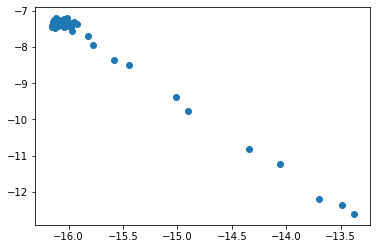

In [12]:
plt.scatter(np.real(result_data), np.imag(result_data))

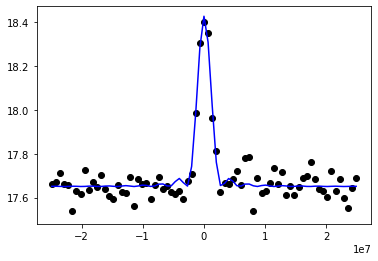

In [13]:
cal.fit_results_f01(result_data,frequencies)

In [15]:
cal.df01_calib/cal.f01_default

7.135638799529116e-06

# amplitude 01

In [16]:
drive_powers,schedules = cal.amplitude01_schedules()

In [17]:
result_data = cal.run_schedule(schedules)

Job Status: job has successfully run


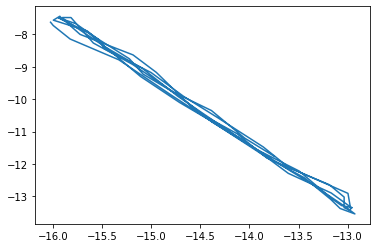

In [18]:
plt.plot(np.real(result_data), np.imag(result_data))

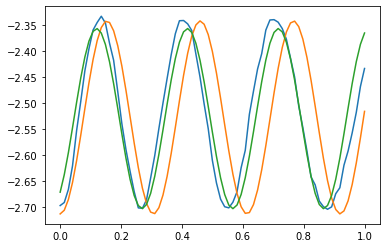

In [19]:
cal.fit_results_a01(result_data,drive_powers)

In [20]:
cal.a01_calib

0.14917816517791702

# frequency 21

In [35]:
frequencies,schedules = cal.frequency12_schedules()

In [36]:
result_data = cal.run_schedule(schedules)

Job Status: job has successfully run


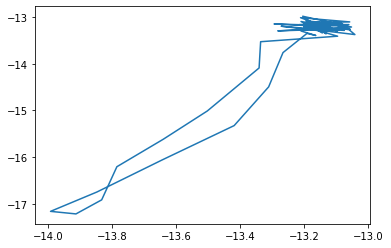

In [37]:
plt.plot(np.real(result_data), np.imag(result_data))

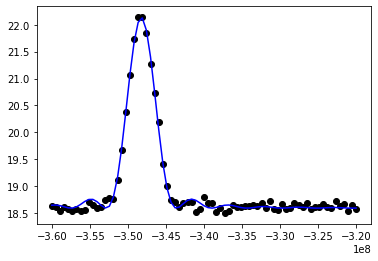

In [42]:
cal.fit_results_f12(result_data,frequencies)

In [43]:
cal.df12_calib

-348238083.6366866

# amplitude 21

In [48]:
drive_powers,schedules = cal.amplitude12_schedules()

In [49]:
result_data = cal.run_schedule(schedules)

Job Status: job has successfully run


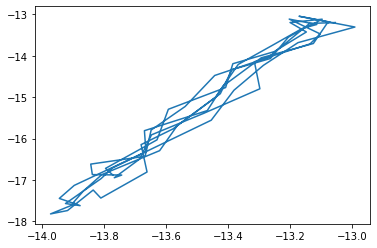

In [50]:
plt.plot(np.real(result_data), np.imag(result_data))

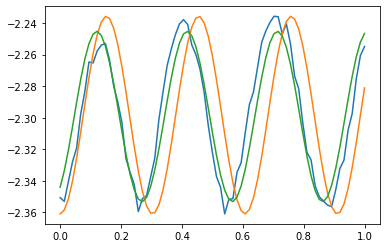

In [58]:
cal.fit_results_a12(result_data,drive_powers)

In [59]:
cal.a12_calib

0.1483563540171458